In [9]:
# Standard library imports
import os
import importlib
from collections import Counter

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

# Configure matplotlib with scienceplots style
import scienceplots
plt.style.use(['science', 'grid'])
plt.rcParams['figure.dpi'] = 500
plt.rcParams.update({
    'font.size': 22,
    'axes.titlesize': 22,
    'axes.labelsize': 22,
    'xtick.labelsize': 22,
    'ytick.labelsize': 22,
})

# Custom module imports
import dataset_pipeline  
importlib.reload(dataset_pipeline)
from dataset_pipeline import (
    DICOMProcessor, Plotter, 
    GBMDataset3D_Survival, DoseLoader, DoseLoaderCache, 
    GBMDataset3D_PFS
)

# Set random seed for reproducibility
random_seed = 42
torch.manual_seed(random_seed)


In [10]:
def patient_response_dict(clinical_data, patient_ids, mapping=None):
    """
    Creates a dictionary with patient ID as the key and a numeric label as the value.
    
    Parameters:
    - clinical_data: Pandas DataFrame containing patient data
    - patient_ids: List of patient IDs
    - mapping: Dictionary mapping string labels to numeric values
    
    Returns:
    - dict: Dictionary with patient ID as key and numeric label as value
    """
    patient_response_dict = {}
    
    for patient_id in patient_ids:
        # Find the correct row for the patient
        patient_row = clinical_data.loc[clinical_data['AnonymPatientID'] == f"Burdenko-GBM-{patient_id:03d}"]
        
        if not patient_row.empty:
            # Retrieve the patient's 'Response_1st_fup' value
            response_value = patient_row['Response_1st_fup'].values[0]
            # Map response_value to a numeric label
            if mapping and response_value in mapping:
                response_label = mapping[response_value]
            elif isinstance(response_value, str):
                # If response_value is a numeric string, convert to int
                try:
                    response_label = int(response_value)
                except ValueError:
                    # If conversion fails, set to a default value or handle as needed
                    response_label = -1
            else:
                # If response_value is already numeric
                response_label = response_value
            # Add to the dictionary
            patient_response_dict[patient_id] = response_label
        else:
            # If patient ID is not found in clinical_data, you can for example assign a None value or a default label
            patient_response_dict[patient_id] = -1  # Use -1 for missing label
    
    return patient_response_dict

def custom_collate_fn(batch):
    collated_batch = {}
    # Collate tensor fields
    tensor_fields = ['image', 'label', 'patient_id', 'age', 'sex', 'idh_status', 'mgmt_status',
                     'survival_time', 'number_of_fractions_planned', 'delivery_maximum_dose', 'prescription_dose']
    for field in tensor_fields:
        collated_batch[field] = torch.stack([item[field] for item in batch])
    # Keep 'slice_contours' and 'structure_masks' as lists
    collated_batch['slice_contours'] = [item['slice_contours'] for item in batch]
    collated_batch['structure_masks'] = [item['structure_masks'] for item in batch]

    return collated_batch

In [11]:
# Read the clinical data
clinical_data = pd.read_csv("Burdenko-GBM-clinical-data.csv")
# Define patient IDs
patient_ids = np.arange(0, 181)

# Filter rows based on the patient IDs
filtered_data = clinical_data.loc[clinical_data['AnonymPatientID'].isin([f"Burdenko-GBM-{pid:03d}" for pid in patient_ids])]

# Extract the 'Response_1st_fup' column and find unique labels
unique_labels = filtered_data['Response_1st_fup'].unique()
print("Unique labels in 'Response_1st_fup':", unique_labels)

# Count the frequency of each label
label_counts = filtered_data['Response_1st_fup'].value_counts()
print("\nCount of each label:")
print(label_counts)


Unique labels in 'Response_1st_fup': ['response' 'progression' 'stable' 'pseudo progression' nan
 'response, distant progression']

Count of each label:
Response_1st_fup
response                         86
stable                           40
pseudo progression               31
progression                      20
response, distant progression     1
Name: count, dtype: int64


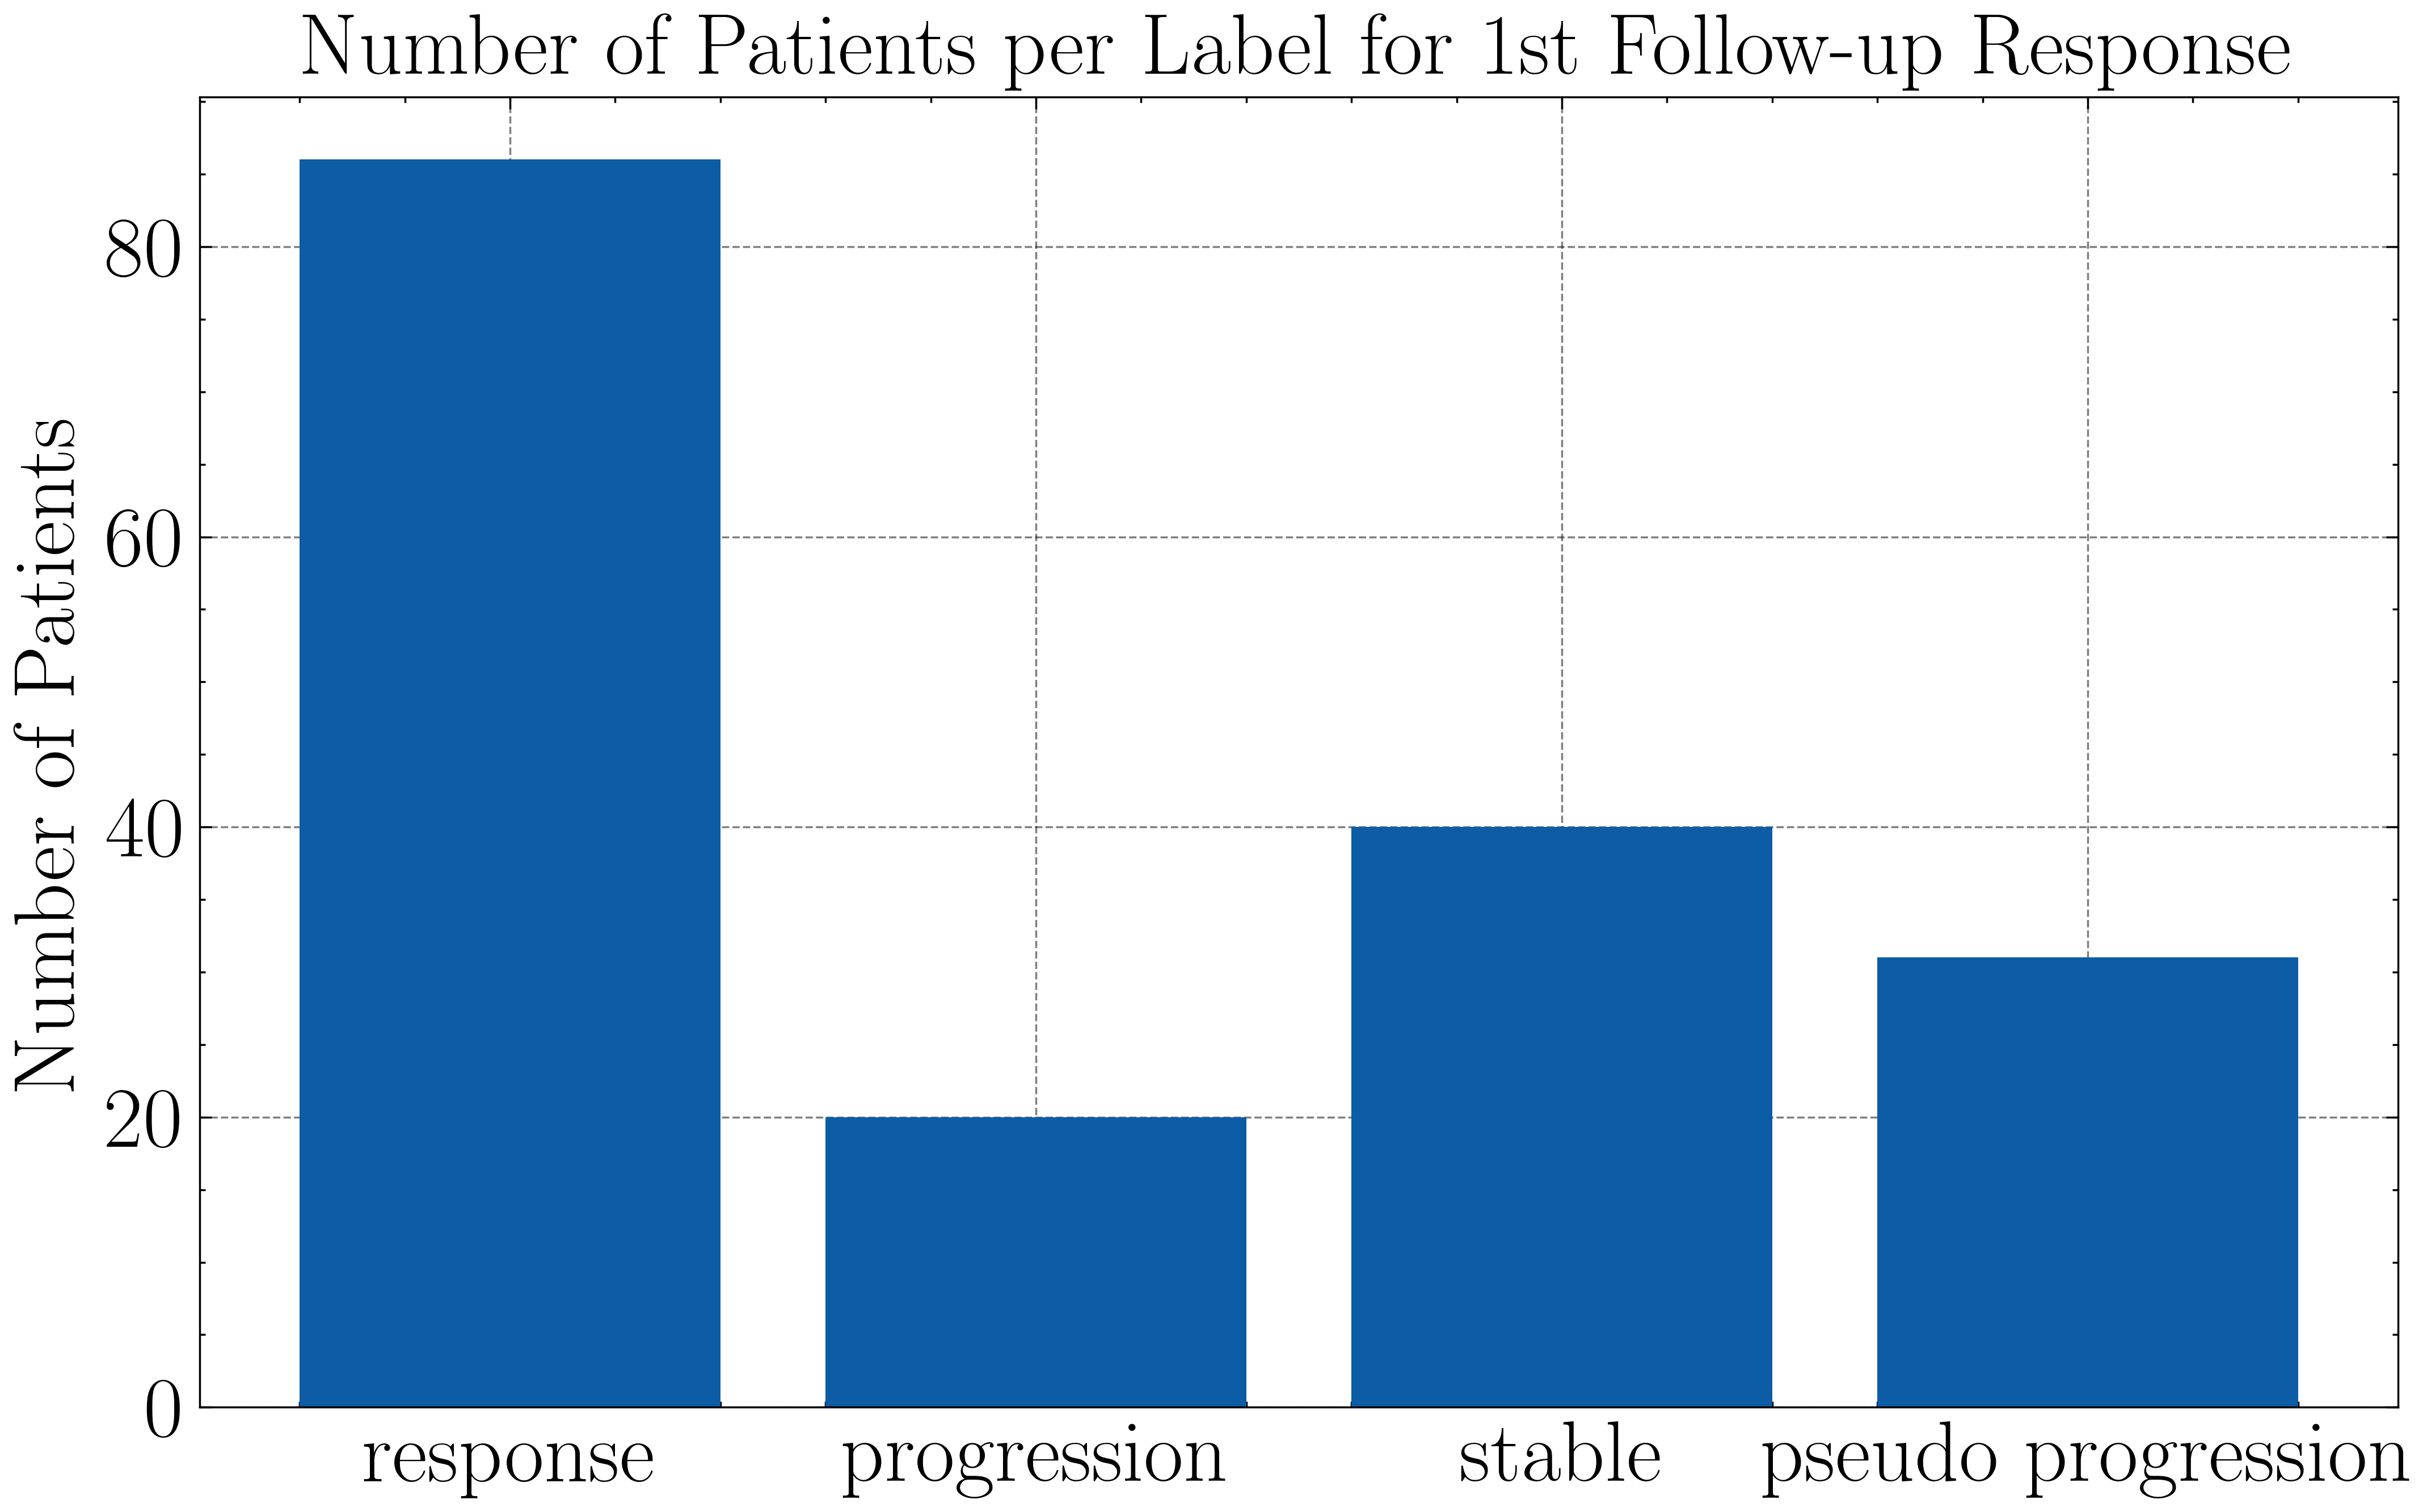

In [12]:
# Define patient IDs
patient_ids = np.arange(0, 181)

# Define mapping for labels
label_mapping = {
    'response': 0,
    'progression': 1,
    'stable': 2,
    'pseudo progression': 3
}

clinical_data = pd.read_csv("Burdenko-GBM-clinical-data.csv")
labels_dict = patient_response_dict(clinical_data, patient_ids, mapping=label_mapping)

# Extract the labels
labels = list(labels_dict.values())

# Use Counter to count the occurrences of each label
label_counts = Counter(labels)

# Create the plot
plt.figure(figsize=(10, 6))
plt.bar(label_mapping.keys(), [label_counts[i] for i in range(len(label_mapping))])
plt.ylabel('Number of Patients')
plt.title('Number of Patients per Label for 1st Follow-up Response')
plt.show()

**Clinical Data**

In [13]:
data = pd.read_csv("Burdenko-GBM-clinical-data.csv")
data.head()

,AnonymPatientID,AnonymStudyDate,Sex,IDH1/2,MGMT,Response_1st_fup,Response_2nd_fup,Response_3rd_fup,Response_4th_fup,Response_5th_fup,...,Anonym3rd_fup,Anonym4th_fup,Anonym5th_fup,Anonym6th_fup,Anonym7th_fup,Anonym8th_fup,Anonym9th_fup,Anonym10th_fup,AnonymDeath,AgeAtStudyDate
0,Burdenko-GBM-001,5/6/04,F,negative,negative,response,stable,stable,stable,stable,...,10/4/04,12/23/04,3/30/05,,,,,,,51.0
1,Burdenko-GBM-002,9/9/04,M,positive,positive,response,response,progression,NaN,NaN,...,6/17/05,,,,,,,,8/11/05,72.0
2,Burdenko-GBM-003,9/8/04,M,NaN,NaN,progression,NaN,NaN,NaN,NaN,...,,,,,,,,,12/5/05,64.0
3,Burdenko-GBM-004,9/5/04,F,negative,positive,stable,progression,progression,NaN,NaN,...,3/23/05,,,,,,,,12/2/06,54.0
4,Burdenko-GBM-005,9/11/04,F,negative,negative,stable,NaN,NaN,NaN,NaN,...,,,,,,,,,,68.0


Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Skipping cropping as it is disabled.


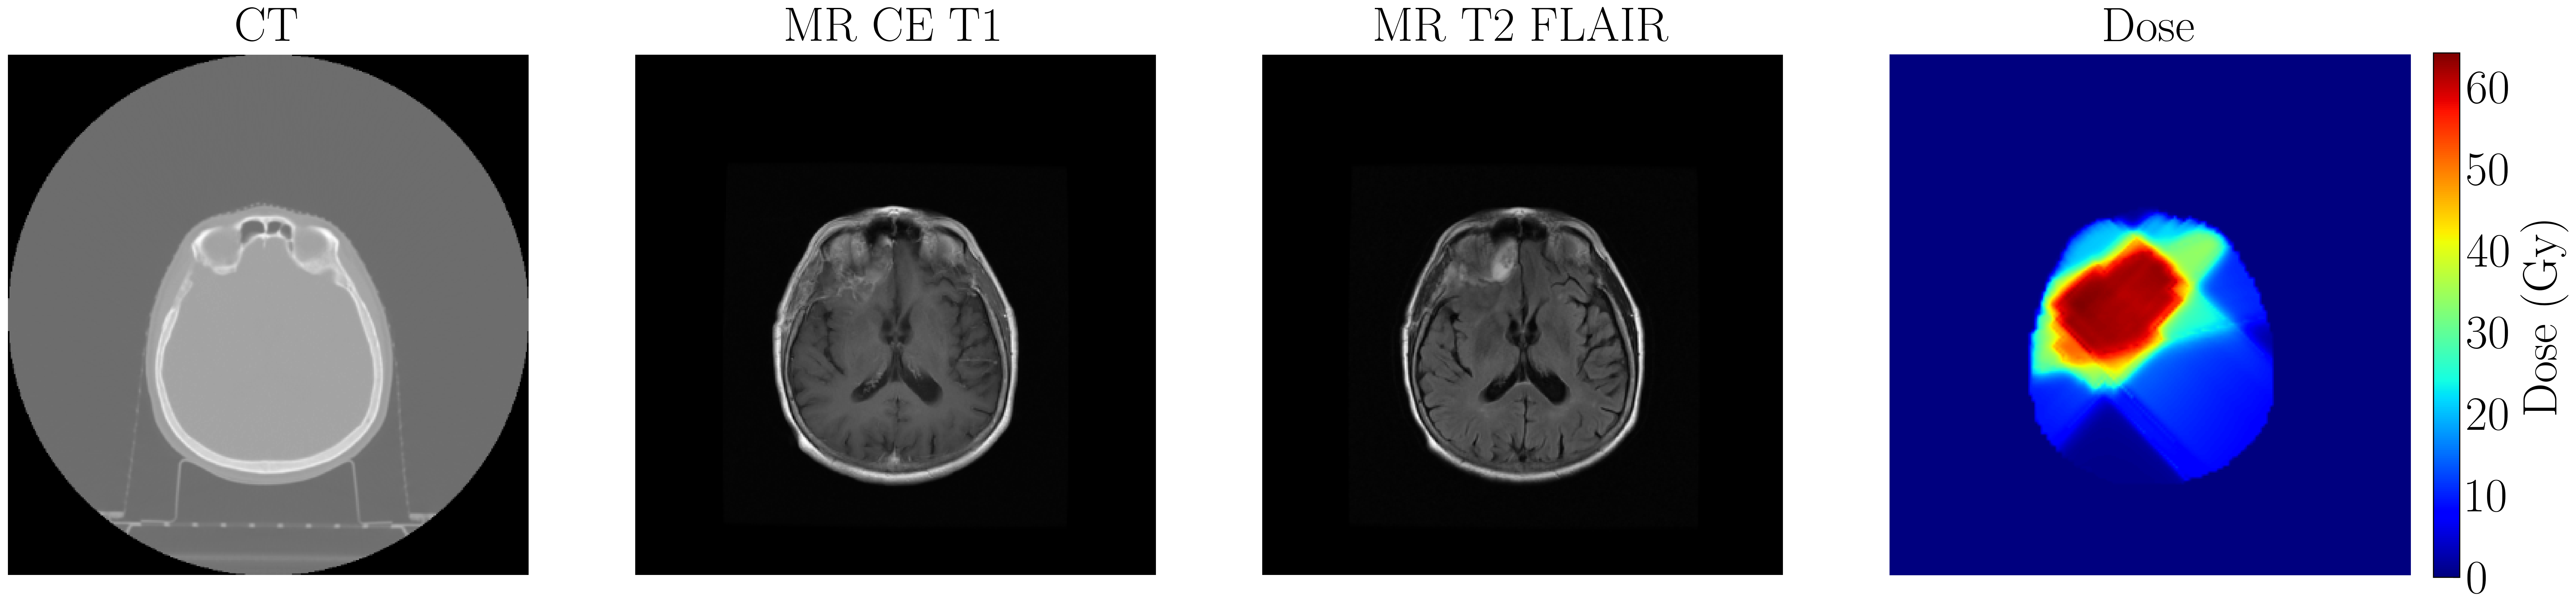

In [19]:

patient_id = 57
base_path = "Burdenko-GBM-Progression"
patient_id = f"Burdenko-GBM-{patient_id:03d}"

processor = DICOMProcessor(patient_id, base_path, verbose=True, bias_correction_enabled=False, apply_cropping=False)
processor.load_all_data()

plotter = Plotter(processor, verbose=False)
slice_idx = 118

fig, axes = plt.subplots(1, 4, figsize=(20, 5), gridspec_kw={'width_ratios': [1, 1, 1, 1.095]})

# Plot CT-slice
plotter.plot_ct_slice(slice_idx, ax=axes[0])
axes[0].set_title('CT')

# Plot MR T1-slice
plotter.plot_mr_t1_slice(slice_idx, ax=axes[1])
axes[1].set_title('MR CE T1')

# Plot MR T2-slice
plotter.plot_mr_t2_slice(slice_idx, ax=axes[2])
axes[2].set_title('MR T2 FLAIR')

# Plot Dose-slice 
plotter.plot_dose_slice(slice_idx, ax=axes[3])
axes[3].set_title('Dose')

plt.savefig("Bilder/visualisation_before_cropping.pdf")
plt.show()

Resampling CT image to standard spacing...
Resampling registered MR T2 image to standard spacing...
Resampling registered MR T1 image to standard spacing...
Resampling RTDOSE image to standard spacing...
Cropping parameters: index=[66, 73, 17], size=[218, 218, 178]


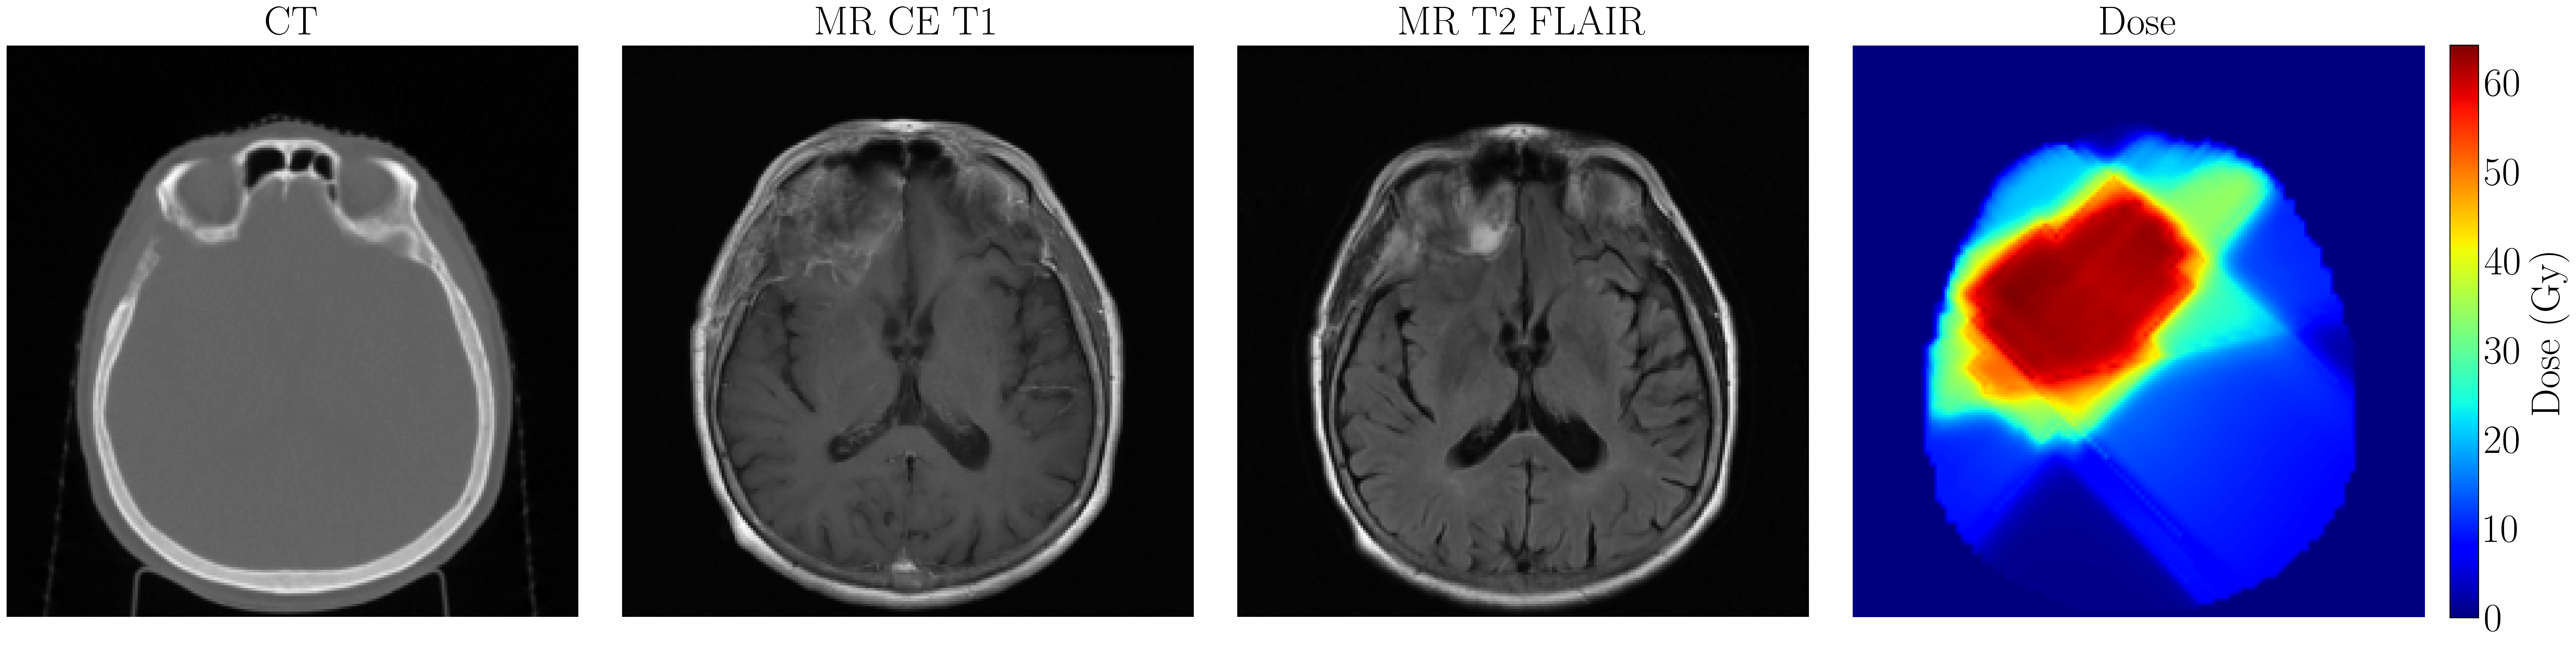

In [20]:
patient_id = 57

base_path = "Burdenko-GBM-Progression"
patient_id = f"Burdenko-GBM-{patient_id:03d}"
# Initialiser DICOMProcessor og last inn data
processor = DICOMProcessor(patient_id, base_path, verbose=True, bias_correction_enabled=False, apply_cropping=True)
processor.load_all_data()

plotter = Plotter(processor, verbose=False)

slice_idx = 100

fig, axes = plt.subplots(1, 4, figsize=(20, 5), gridspec_kw={'width_ratios': [1, 1, 1, 1.095]})
# Plot CT-slice
plotter.plot_ct_slice(slice_idx, ax=axes[0])
axes[0].set_title('CT')

# Plot MR T1-slice
plotter.plot_mr_t1_slice(slice_idx, ax=axes[1])
axes[1].set_title('MR CE T1')

# Plot MR T2-slice
plotter.plot_mr_t2_slice(slice_idx, ax=axes[2])
axes[2].set_title('MR T2 FLAIR')

# Plot Dose-slice 
plotter.plot_dose_slice(slice_idx, ax=axes[3])
axes[3].set_title('Dose')

plt.tight_layout()
plt.savefig("Bilder/visualisation_after_cropping.pdf")
plt.show()

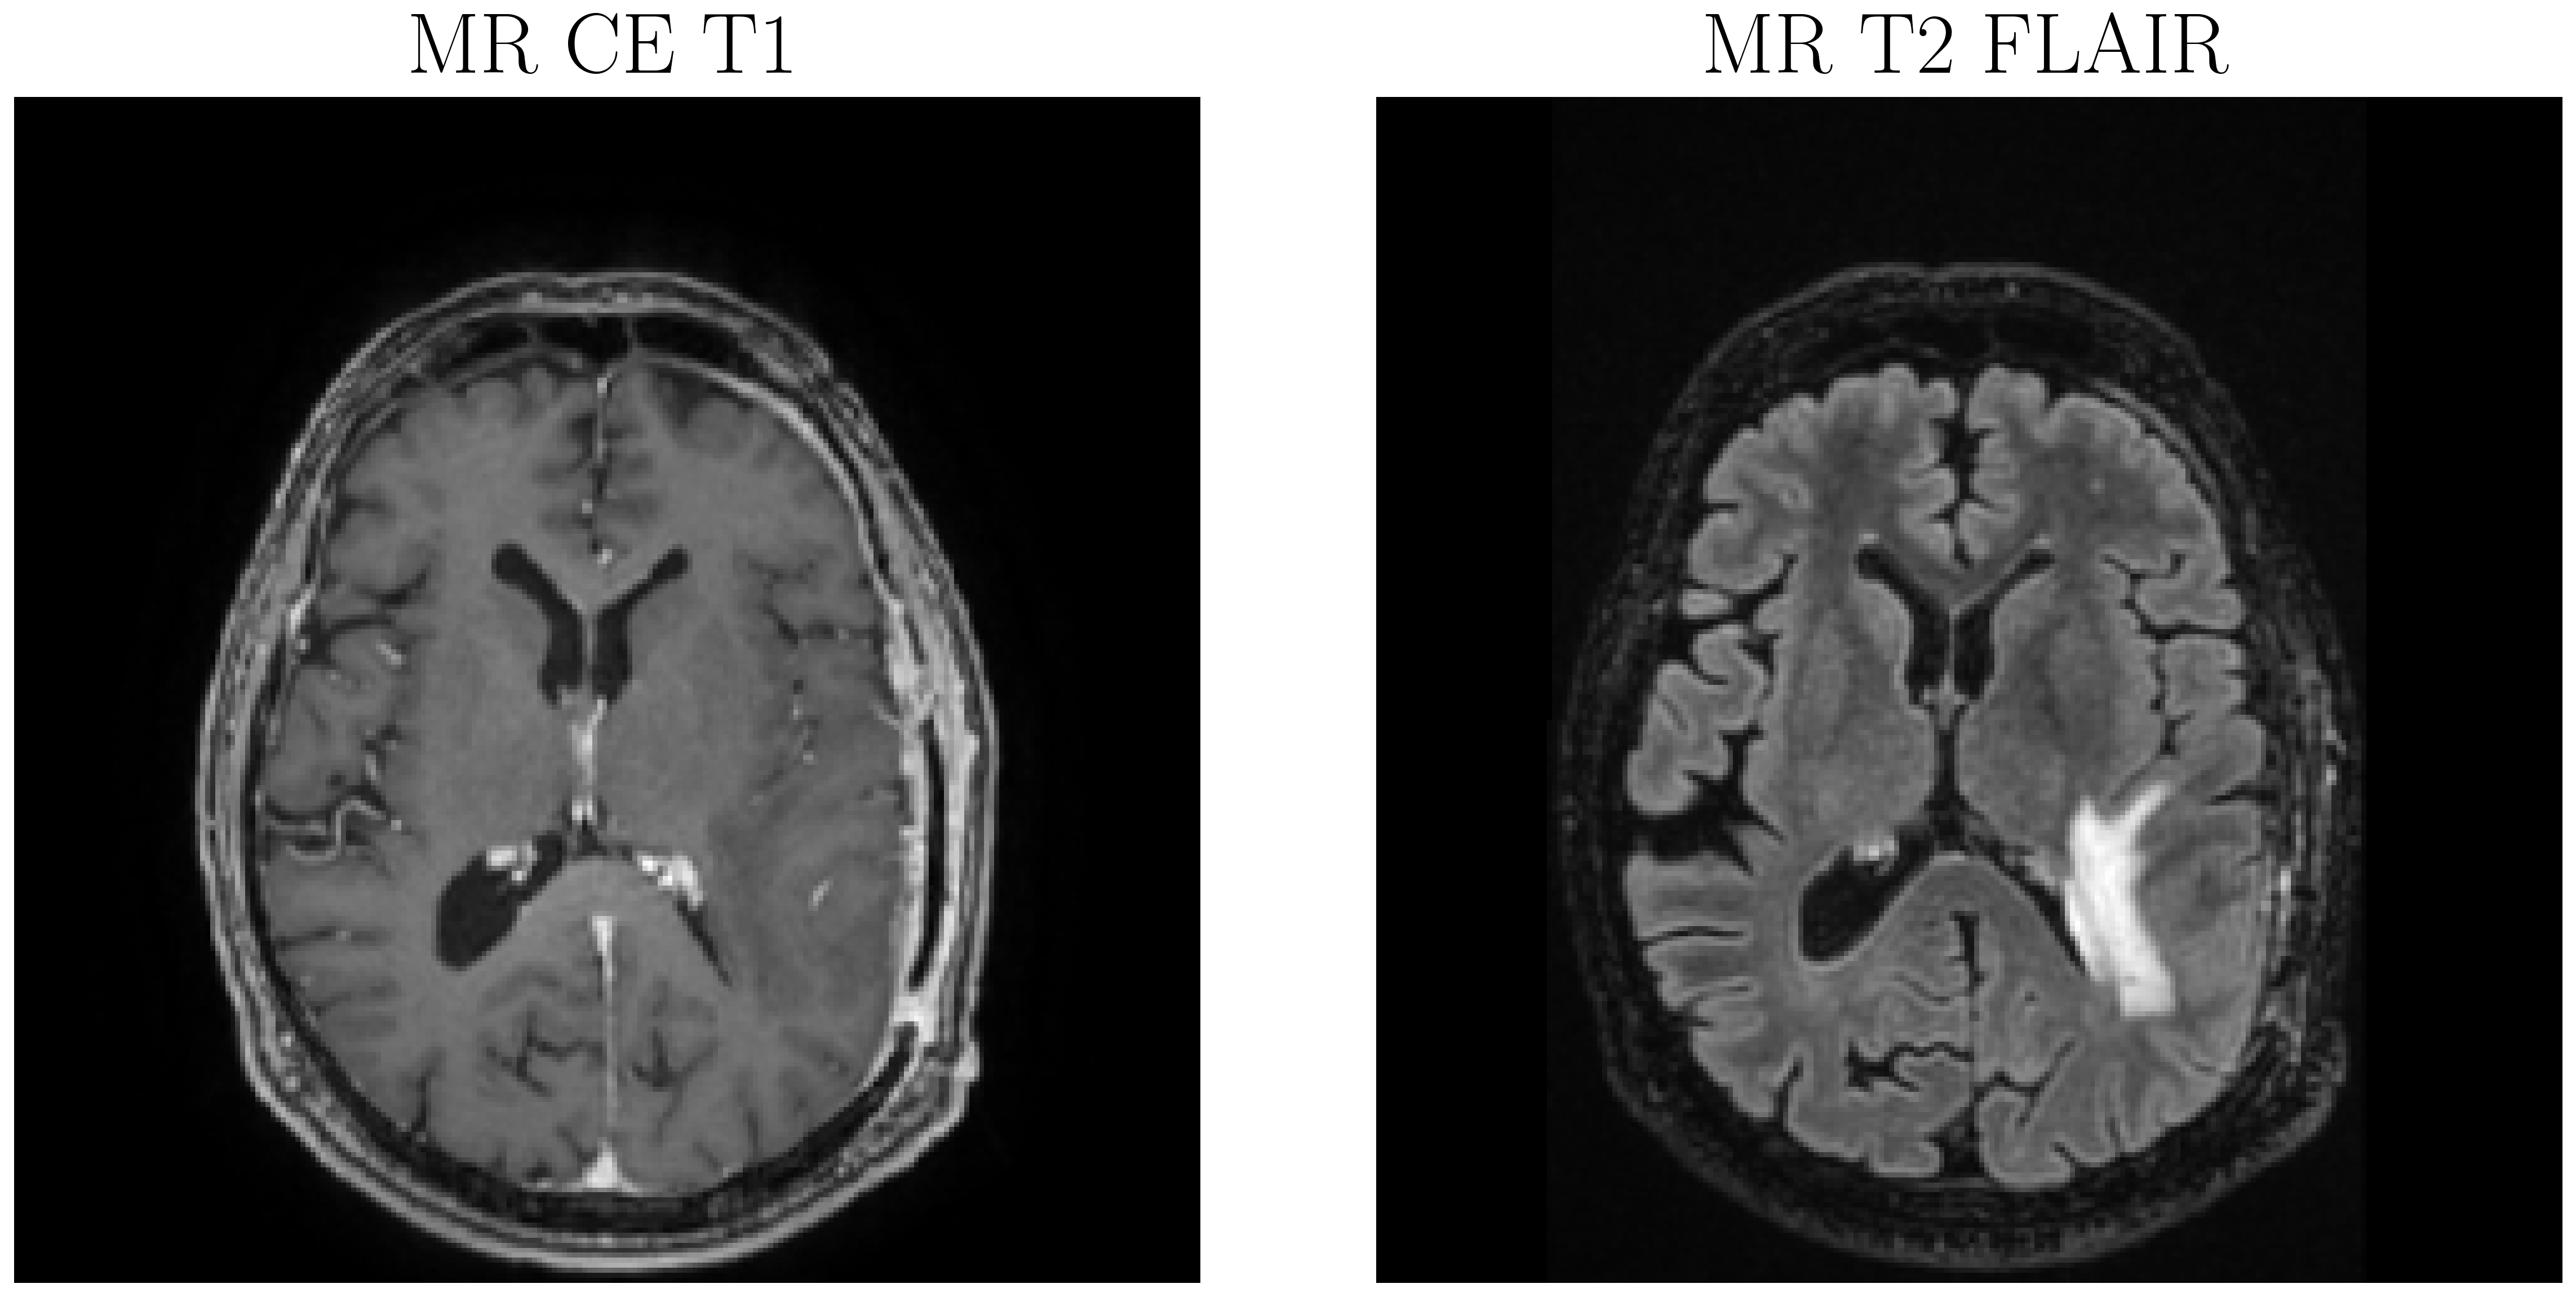

In [13]:
patient_id = 15
base_path = "Burdenko-GBM-Progression"
patient_id = f"Burdenko-GBM-{patient_id:03d}"
# Initialiser DICOMProcessor og last inn data
processor = DICOMProcessor(patient_id, base_path, verbose=False, bias_correction_enabled=True)
processor.load_all_data()
# Initialiser Plotter
plotter = Plotter(processor, verbose=False)

# Velg slice-indeks
slice_idx = 165

# Opprett subplots for MR T1 og MR T2
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot MR T1-slice
plotter.plot_mr_t1_slice(slice_idx, ax=axes[0])
axes[0].set_title('MR CE T1')

# Plot MR T2-slice
plotter.plot_mr_t2_slice(slice_idx, ax=axes[1])
axes[1].set_title('MR T2 FLAIR')

plt.tight_layout()
plt.savefig("Bilder/exampleGBM_T1_T2.pdf")
plt.show()

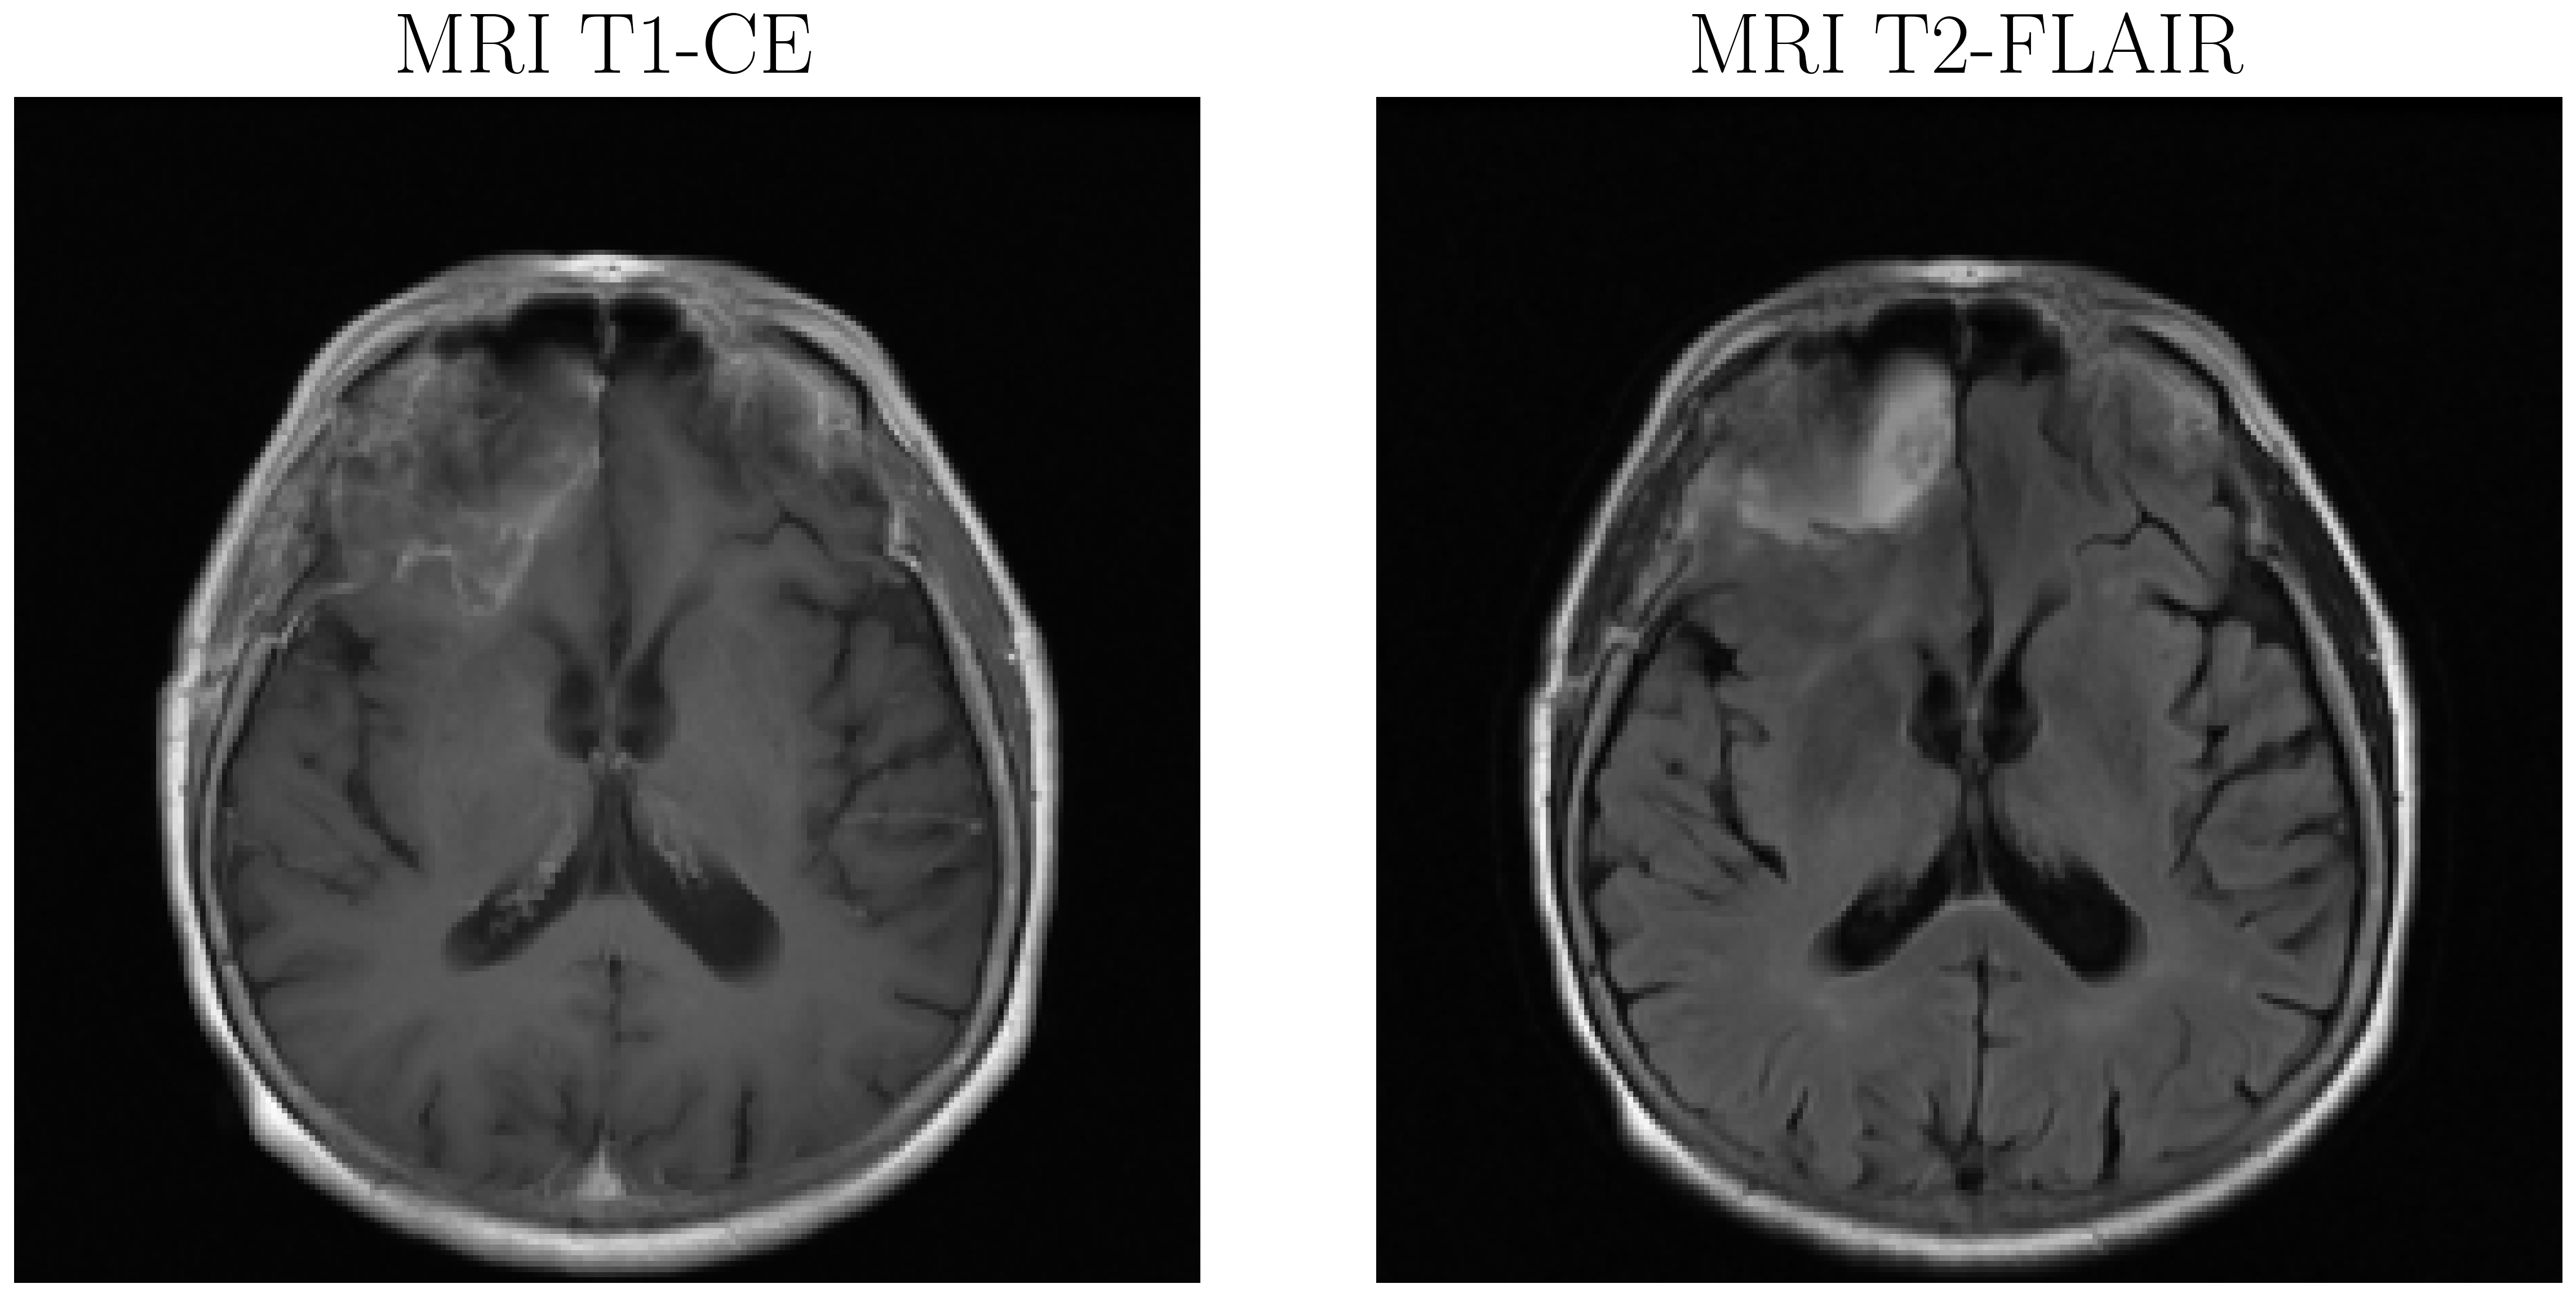

In [ ]:
# Base path og pasient-ID
patient_id = 57
base_path = "Burdenko-GBM-Progression"
patient_id = f"Burdenko-GBM-{patient_id:03d}"
# Initialiser DICOMProcessor og last inn data
processor = DICOMProcessor(patient_id, base_path, verbose=False, bias_correction_enabled=False)
processor.load_all_data()

# Initialiser Plotter
plotter = Plotter(processor, verbose=False)

# Velg slice-indeks
slice_idx = 100

# Opprett subplots for MR T1 og MR T2
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot MR T1-slice
plotter.plot_mr_t1_slice(slice_idx, ax=axes[0])
axes[0].set_title('MRI T1-CE')

# Plot MR T2-slice
plotter.plot_mr_t2_slice(slice_idx, ax=axes[1])
axes[1].set_title('MRI T2-FLAIR')

# Juster layout og vis plottet
plt.tight_layout()
plt.savefig("Bilder/visualisation_before_bias.pdf")
plt.show()

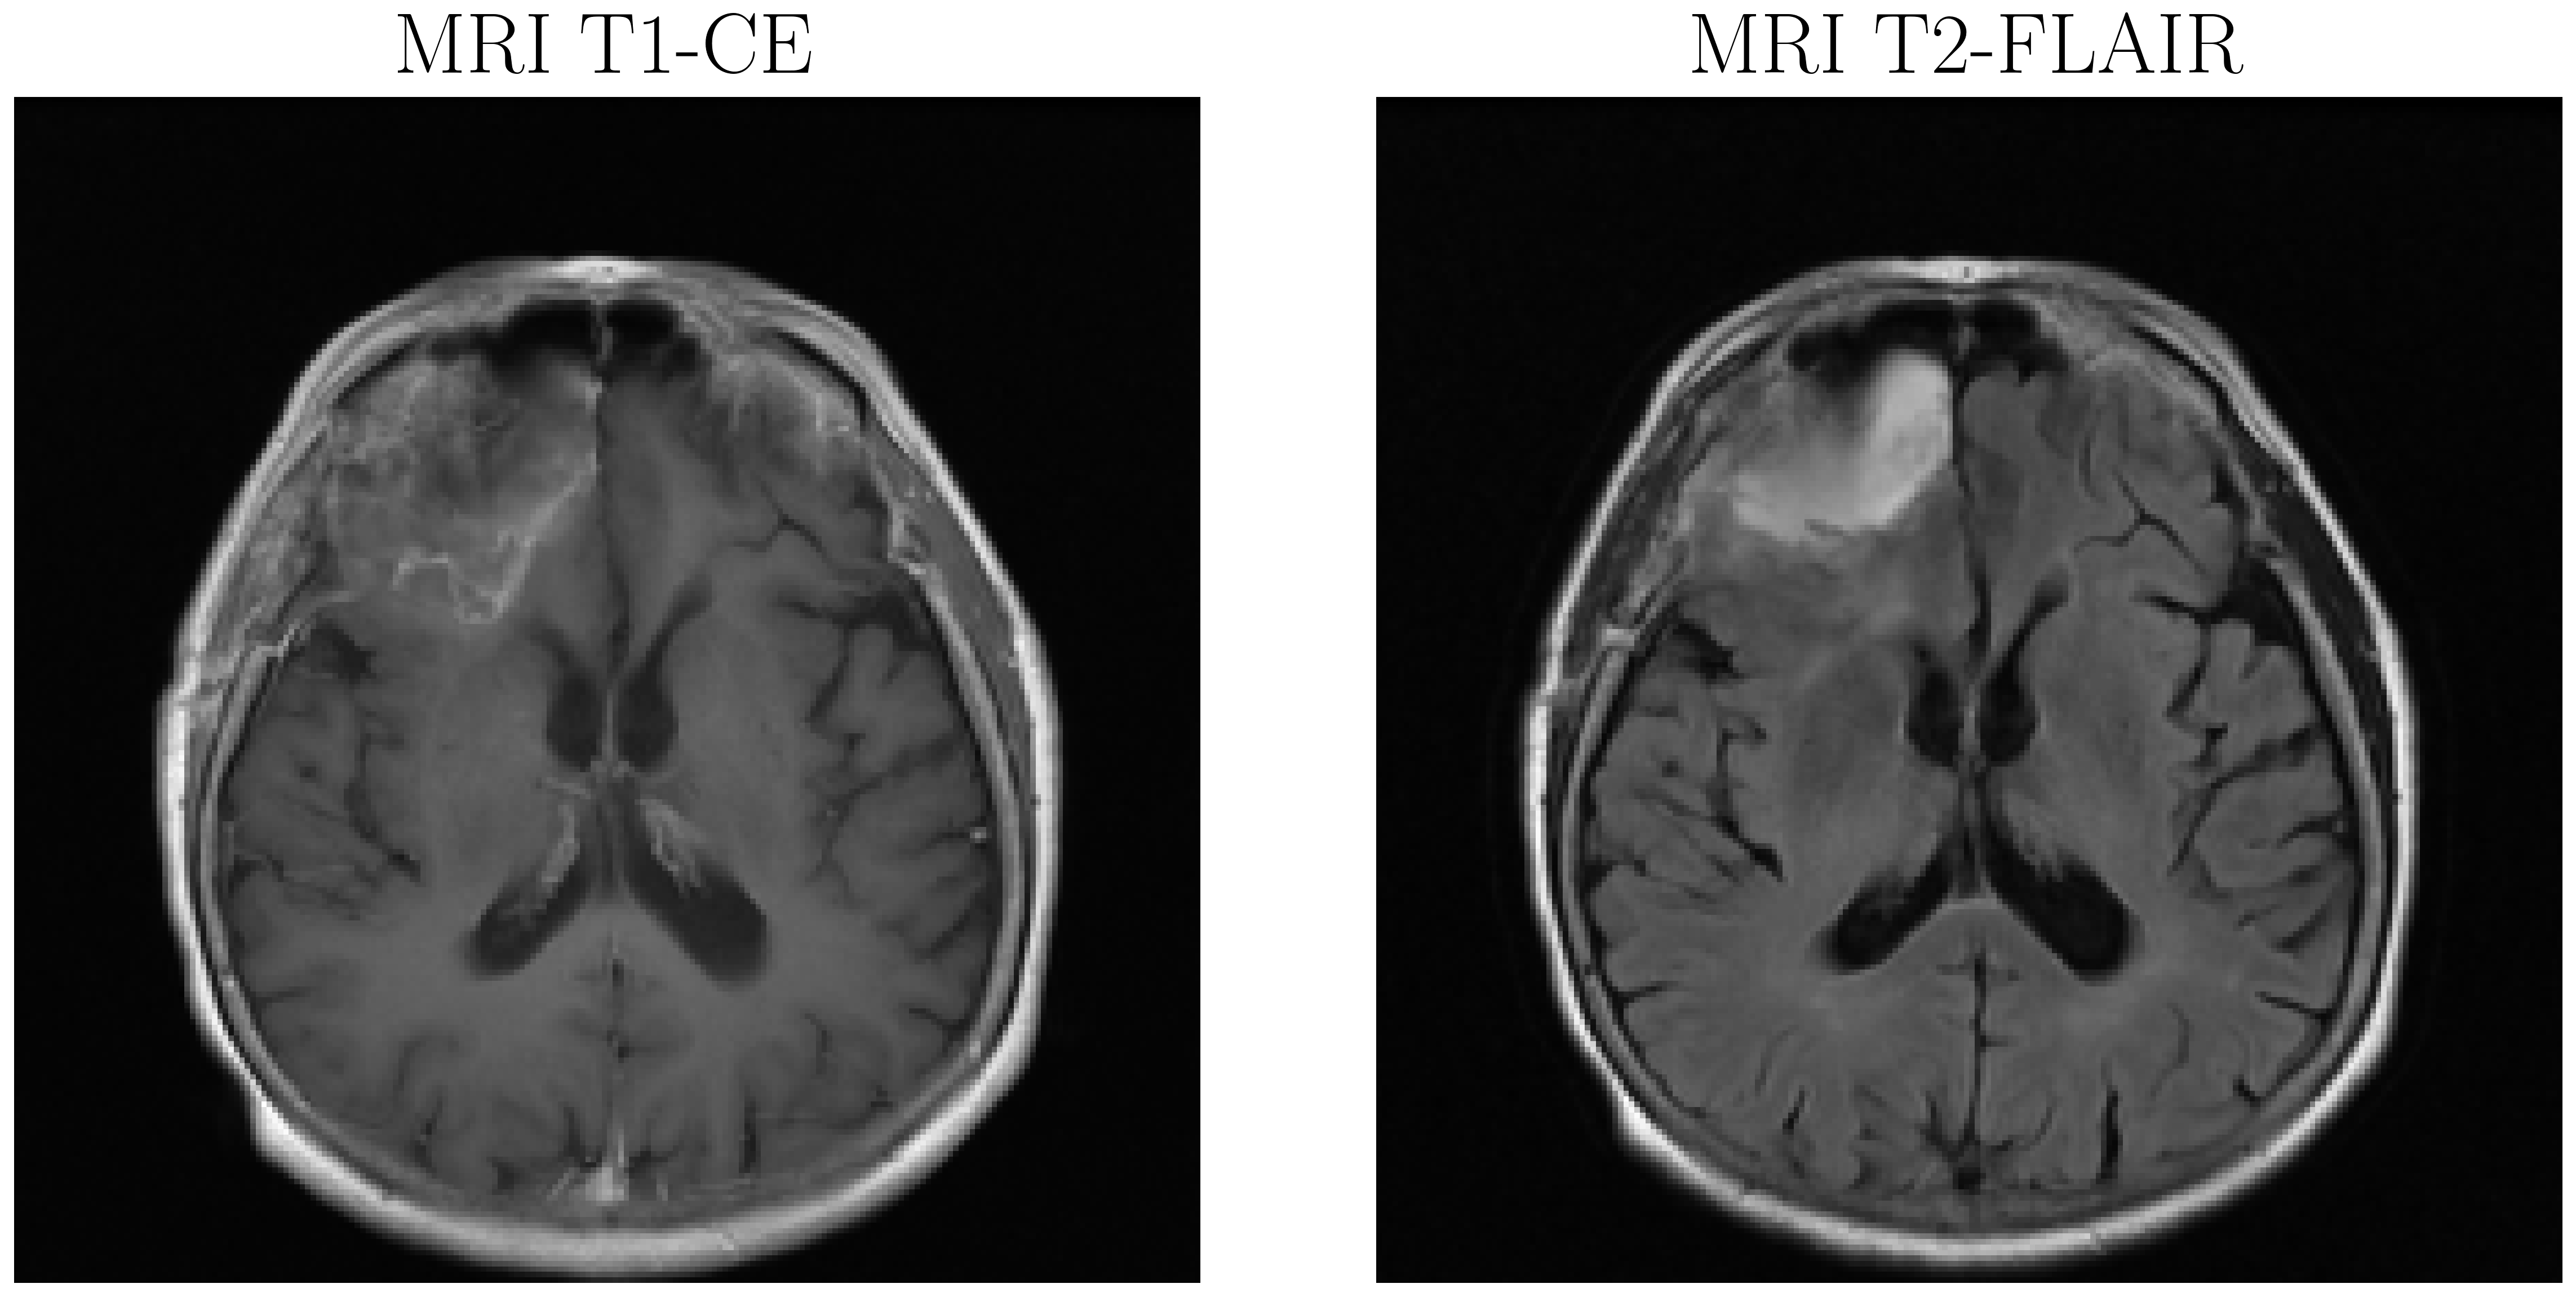

In [ ]:
# Base path og pasient-ID
patient_id = 57
base_path = "Burdenko-GBM-Progression"
patient_id = f"Burdenko-GBM-{patient_id:03d}"
# Initialiser DICOMProcessor og last inn data
processor = DICOMProcessor(patient_id, base_path, verbose=False, bias_correction_enabled=True)
processor.load_all_data()

# Initialiser Plotter
plotter = Plotter(processor, verbose=False)

# Velg slice-indeks
slice_idx = 100

# Opprett subplots for MR T1 og MR T2
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot MR T1-slice
plotter.plot_mr_t1_slice(slice_idx, ax=axes[0])
axes[0].set_title('MRI T1-CE')

# Plot MR T2-slice
plotter.plot_mr_t2_slice(slice_idx, ax=axes[1])
axes[1].set_title('MRI T2-FLAIR')

# Juster layout og vis plottet
plt.tight_layout()
plt.savefig("Bilder/visualisation_after_bias.pdf")
plt.show()

In [25]:
print("Number of slices in MRI:", processor.mr_array.shape)

Number of slices in MRI: (23, 512, 512)


In [22]:

def save_dataset_to_disk(dataset, save_path, verbose=True, start_idx=1):
    """
    Lagre hver prøve i datasettet til disk som individuelle .pt filer.
    Starter fra `start_idx` hvis spesifisert.

    Args:
        dataset (torch.utils.data.Dataset): Datasettet som skal lagres.
        save_path (str): Katalogsti hvor prøvene skal lagres.
        verbose (bool): Hvis True, viser fremdrift.
        start_idx (int): Indeks å starte lagringen fra.
    """
    os.makedirs(save_path, exist_ok=True)
    
    if verbose:
        print(f"Lagrer {len(dataset)} prøver til {save_path}...")
    
    for idx in tqdm(range(len(dataset)), disable=not verbose):
        sample_path = os.path.join(save_path, f"sample_{idx + start_idx}.pt")
        if os.path.exists(sample_path):
            if verbose:
                print(f"Prøve {idx + start_idx} eksisterer allerede. Hopper over.")
            continue  # Hopper over eksisterende filer
        sample = dataset[idx]
        torch.save(sample, sample_path)
    
    if verbose:
        print("Lagring fullført.")



def combine_pt_files(source_dir, combined_file_path, verbose=True):
    """
    Combines all .pt files in the source directory into a single dataset and saves it.

    Args:
        source_dir (str): Directory containing individual .pt files.
        combined_file_path (str): Path where the combined dataset will be saved.
        verbose (bool): If True, prints progress.
    """
    if verbose:
        print(f"Combining .pt files from {source_dir} into {combined_file_path}...")
    
    combined_data = []
    
    # List all .pt files in the source directory
    pt_files = [f for f in os.listdir(source_dir) if f.endswith('.pt')]
    
    if verbose:
        print(f"Found {len(pt_files)} '.pt'-files.")
    
    for pt_file in tqdm(pt_files, disable=not verbose):
        file_path = os.path.join(source_dir, pt_file)
        sample = torch.load(file_path)
        combined_data.append(sample)
    torch.save(combined_data, combined_file_path)
    
    if verbose:
        print(f"Combined dataset saved to {combined_file_path}.")

**SURVIVAL**

In [23]:
filtered_data = pd.read_csv('filtered_data_with_dose_features.csv')
filtered_data['MGMT'].replace('?', np.nan, inplace=True)

/var/folders/xp/h3dtp5cs1lzd65bpc1c7z3dr0000gn/T/ipykernel_3379/3686831799.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  filtered_data['MGMT'].replace('?', np.nan, inplace=True)


In [24]:
# Les inn CSV-filen
filtered_data_csv = 'filtered_data_with_dose_features.csv'
filtered_data = pd.read_csv(filtered_data_csv)

# Skriv ut kolonnenavnene
print("Kolonnenavn i CSV-filen:")
print(filtered_data.columns.tolist())


Kolonnenavn i CSV-filen:
['AnonymPatientID', 'AnonymStudyDate', 'Sex', 'IDH1/2', 'MGMT', 'Response_1st_fup', 'Response_2nd_fup', 'Response_3rd_fup', 'Response_4th_fup', 'Response_5th_fup', 'Response_6th_fup', 'Response_7th_fup', 'Response_8th_fup', 'Response_9th_fup', 'Response_10th_fup', 'AnonymDate of surgery', 'AnonymStart of RT', 'AnonymEnd of RT', 'AnonymDate of topometric MRI', 'Anonym1st_fup', 'Anonym2nd_fup', 'Anonym3rd_fup', 'Anonym4th_fup', 'Anonym5th_fup', 'Anonym6th_fup', 'Anonym7th_fup', 'Anonym8th_fup', 'Anonym9th_fup', 'Anonym10th_fup', 'AnonymDeath', 'AgeAtStudyDate', 'FirstValidFollowUp', 'LastValidFollowUp', 'FirstFollowUpNumber', 'DaysToFirstValidFollowUp', 'DaysFromRTToLastFollowUp', 'num_followups', 'progression_count', 'combined_survival', 'DaysFromEndRTToFirstFollowUp', 'DaysFromStudyDateToStartRT', 'Unnamed: 0', 'Patient_ID', '1_GTV=CTV_pituitary_adenoma_(T1+contr)', '2_CTV_gs+pa(+1.5cm)', '2_GTV_gs_(FLAIR)', 'BOOST', 'Bones', 'Brain', 'Chiasm', 'Cochlea', 'Coch

## Creation of the Survival Dataset

In [25]:
base_path = "Burdenko-GBM-Progression"
gbm_dataset = GBMDataset3D_Survival(
    filtered_data_csv=filtered_data_csv,
    base_path=base_path,
    transform=None,
    verbose=False,
    cache_size=10,
    select_top_slices=True,
    num_slices=100,
    target_spacing=(1, 1, 1) # voxel spacing in mm
)

train_size = int(0.8 * len(gbm_dataset))
val_size = len(gbm_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(gbm_dataset, [train_size, val_size])
train_save_path = "PyTorch Datasets Survival/training"
val_save_path = "PyTorch Datasets Survival/validation"
combined_train_path = "PyTorch Datasets Survival/train_dataset_survival_preprocessed.pt"
combined_val_path = "PyTorch Datasets Survival/val_dataset_survival_preprocessed.pt"

#Save train dataset samples to disk
save_dataset_to_disk(train_dataset, train_save_path, verbose=True)
save_dataset_to_disk(val_dataset, val_save_path, verbose=True)
#combine_pt_files(train_save_path, combined_train_path)
#combine_pt_files(val_save_path, combined_val_path)

Lagrer 69 prøver til PyTorch Datasets Survival/training...


100%|██████████| 69/69 [00:00<00:00, 2623.08it/s]


Prøve 1 eksisterer allerede. Hopper over.
Prøve 2 eksisterer allerede. Hopper over.
Prøve 3 eksisterer allerede. Hopper over.
Prøve 4 eksisterer allerede. Hopper over.
Prøve 5 eksisterer allerede. Hopper over.
Prøve 6 eksisterer allerede. Hopper over.
Prøve 7 eksisterer allerede. Hopper over.
Prøve 8 eksisterer allerede. Hopper over.
Prøve 9 eksisterer allerede. Hopper over.
Prøve 10 eksisterer allerede. Hopper over.
Prøve 11 eksisterer allerede. Hopper over.
Prøve 12 eksisterer allerede. Hopper over.
Prøve 13 eksisterer allerede. Hopper over.
Prøve 14 eksisterer allerede. Hopper over.
Prøve 15 eksisterer allerede. Hopper over.
Prøve 16 eksisterer allerede. Hopper over.
Prøve 17 eksisterer allerede. Hopper over.
Prøve 18 eksisterer allerede. Hopper over.
Prøve 19 eksisterer allerede. Hopper over.
Prøve 20 eksisterer allerede. Hopper over.
Prøve 21 eksisterer allerede. Hopper over.
Prøve 22 eksisterer allerede. Hopper over.
Prøve 23 eksisterer allerede. Hopper over.
Prøve 24 eksisterer 

  0%|          | 0/18 [00:00<?, ?it/s]

Prøve 1 eksisterer allerede. Hopper over.
Prøve 2 eksisterer allerede. Hopper over.
Prøve 3 eksisterer allerede. Hopper over.
Prøve 4 eksisterer allerede. Hopper over.
Prøve 5 eksisterer allerede. Hopper over.
Prøve 6 eksisterer allerede. Hopper over.
Prøve 7 eksisterer allerede. Hopper over.
Prøve 8 eksisterer allerede. Hopper over.
Prøve 9 eksisterer allerede. Hopper over.
Prøve 10 eksisterer allerede. Hopper over.
Prøve 11 eksisterer allerede. Hopper over.
Prøve 12 eksisterer allerede. Hopper over.
Prøve 13 eksisterer allerede. Hopper over.
Prøve 14 eksisterer allerede. Hopper over.
Prøve 15 eksisterer allerede. Hopper over.
Prøve 16 eksisterer allerede. Hopper over.
Prøve 17 eksisterer allerede. Hopper over.


100%|██████████| 18/18 [01:44<00:00,  5.79s/it]

Lagring fullført.


## Progression-Free Survival dataset

In [26]:
pfs_file = pd.read_csv('PFS_data.csv')
clinical_data = pd.read_csv('Burdenko-GBM-clinical-data.csv')

# Oppdater 'AnonymPatientID'-kolonnen i clinical_data slik at alle ID-er har tre sifre
clinical_data['AnonymPatientID'] = clinical_data['AnonymPatientID'].apply(
    lambda x: f"Burdenko-GBM-{int(x.split('-')[-1]):03d}"
)

# Finn felles kolonner (unntatt 'AnonymPatientID' som brukes til merge)
common_columns = [col for col in pfs_file.columns if col in clinical_data.columns and col != 'AnonymPatientID']

# Fjern de felles kolonnene fra pfs_file slik at vi ikke får duplikater
pfs_file_unique = pfs_file.drop(columns=common_columns)

# Merge dataene basert på 'AnonymPatientID'
merged_data = pd.merge(clinical_data, pfs_file_unique, on='AnonymPatientID', how='inner')

print(f"Antall pasienter etter merge (med dødsdato eller progresjon): {len(merged_data)}")
merged_data


Antall pasienter etter merge (med dødsdato eller progresjon): 176


,AnonymPatientID,AnonymStudyDate,Sex,IDH1/2,MGMT,Response_1st_fup,Response_2nd_fup,Response_3rd_fup,Response_4th_fup,Response_5th_fup,...,Anonym6th_fup,Anonym7th_fup,Anonym8th_fup,Anonym9th_fup,Anonym10th_fup,AnonymDeath,AgeAtStudyDate,PFS_months,PFS_event,Days_between_surgery_and_RT
0,Burdenko-GBM-001,5/6/04,F,negative,negative,response,stable,stable,stable,stable,...,,,,,,,51.0,10.479632,0.0,35
1,Burdenko-GBM-002,9/9/04,M,positive,positive,response,response,progression,NaN,NaN,...,,,,,,8/11/05,72.0,5.124836,1.0,151
2,Burdenko-GBM-003,9/8/04,M,NaN,NaN,progression,NaN,NaN,NaN,NaN,...,,,,,,12/5/05,64.0,2.299606,1.0,119
3,Burdenko-GBM-004,9/5/04,F,negative,positive,stable,progression,progression,NaN,NaN,...,,,,,,12/2/06,54.0,4.960578,1.0,34
4,Burdenko-GBM-005,9/11/04,F,negative,negative,stable,NaN,NaN,NaN,NaN,...,,,,,,,68.0,2.036794,0.0,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,Burdenko-GBM-176,1/28/05,F,negative,NaN,response,NaN,NaN,NaN,NaN,...,,,,,,,56.0,1.872536,0.0,16
172,Burdenko-GBM-177,1/28/05,F,negative,NaN,response,response,NaN,NaN,NaN,...,,,,,,,44.0,3.350854,0.0,12
173,Burdenko-GBM-178,7/10/05,M,negative,positive,progression,NaN,NaN,NaN,NaN,...,,,,,,,38.0,2.102497,1.0,43
174,Burdenko-GBM-179,7/30/04,F,negative,negative,response,stable,stable,progression,NaN,...,,,,,,,37.0,9.822602,1.0,36


In [27]:
def create_dose_parameters_csv(base_path, output_file):
    results = []
    patient_folders = [f for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f))]
    
    for patient_id in patient_folders:
        try:
            loader = DoseLoader(patient_id, base_path, dose_threshold_percentage=95.0, verbose=False)
            if loader.registered_dose is None:
                continue
                
            dose_array = loader.get_dose_array()
            max_dose = float(dose_array.max())
            mean_dose = float(dose_array.mean())
            
            v95 = loader.calculate_volume(loader.registered_dose, 95.0)
            v90 = loader.calculate_volume(loader.registered_dose, 90.0)
            v50 = loader.calculate_volume(loader.registered_dose, 50.0)
            v1  = loader.calculate_volume(loader.registered_dose, 1.0)
            
            # Optionally, get structure-specific metrics (e.g., for the brainstem)
            brainstem_vol = loader.get_structure_volume("brain stem")
            brainstem_dose = loader.get_structure_dose_metrics("brainstem")
            
            patient_data = {
                'patient_id': patient_id,
                'prescription_dose': loader.prescription_dose,
                'num_fractions': loader.number_of_fractions_planned,
                'max_dose': max_dose,
                'mean_dose': mean_dose,
                'V95': v95,
                'V90': v90,
                'V50': v50,
                'V1': v1,
                'brainstem_volume_cm3': brainstem_vol,
                'brainstem_mean_dose': brainstem_dose["mean_dose"] if brainstem_dose else None,
                'brainstem_max_dose': brainstem_dose["max_dose"] if brainstem_dose else None
            }
            results.append(patient_data)
            
        except Exception as e:
            print(f"Error processing patient {patient_id}: {e}")
            continue

    df = pd.DataFrame(results)
    df.to_csv(output_file, index=False)

base_path = "Burdenko-GBM-Progression"
output_file = "dose_parameters.csv"
#create_dose_parameters_csv(base_path, output_file)

In [28]:
dose_data = pd.read_csv('dose_parameters.csv')
dose_data.head()

,patient_id,prescription_dose,num_fractions,max_dose,mean_dose,V95,V90,V50,V1,brainstem_volume_cm3,brainstem_mean_dose,brainstem_max_dose
0,Burdenko-GBM-001,63.0,30,74.504501,1.216526,0.388268,14.162727,349.456969,3387.004219,58.906757,5.984726,40.907593
1,Burdenko-GBM-002,45.0,15,46.857006,1.658306,188.709269,253.110949,449.100596,4274.242278,34.990106,8.816372,40.612152
2,Burdenko-GBM-003,60.0,30,65.167854,2.666567,168.607798,324.695592,571.541696,5015.480905,20.259015,23.251030,60.335571
3,Burdenko-GBM-004,60.0,30,62.361675,1.639953,140.807458,179.884241,326.334092,3787.597290,34.645244,21.907372,61.885330
4,Burdenko-GBM-005,60.0,30,62.996681,3.546950,251.829389,437.657818,794.038992,5048.818323,53.470767,25.346563,62.692081


### PFS dataset creation

In [29]:
PFS_dataset = GBMDataset3D_PFS(
    filtered_data_csv=merged_data,
    base_path='Burdenko-GBM-Progression',
    transform=None,
    verbose=True,
    cache_size=10,
    select_top_slices=True,
    num_slices=100,
    target_spacing=(1, 1, 1)
)

train_size = int(0.8 * len(PFS_dataset))
val_size = len(PFS_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(PFS_dataset, [train_size, val_size])
train_save_path = "PyTorch Datasets PFS/training"
val_save_path = "PyTorch Datasets PFS/validation"
combined_train_path = "PyTorch Datasets PFS/train_dataset_PFS_preprocessed.pt"
combined_val_path = "PyTorch Datasets PFS/val_dataset_PFS_preprocessed.pt"

save_dataset_to_disk(train_dataset, train_save_path, verbose=True)
save_dataset_to_disk(val_dataset, val_save_path, verbose=True)
#combine_pt_files(train_save_path, combined_train_path)
#combine_pt_files(val_save_path, combined_val_path)

Imputation of numerical features...
One-hot encoding categorical features...
Normalizing numerical features...
Lagrer 140 prøver til PyTorch Datasets PFS/training...


100%|██████████| 140/140 [00:00<00:00, 3667.13it/s]


Prøve 1 eksisterer allerede. Hopper over.
Prøve 2 eksisterer allerede. Hopper over.
Prøve 3 eksisterer allerede. Hopper over.
Prøve 4 eksisterer allerede. Hopper over.
Prøve 5 eksisterer allerede. Hopper over.
Prøve 6 eksisterer allerede. Hopper over.
Prøve 7 eksisterer allerede. Hopper over.
Prøve 8 eksisterer allerede. Hopper over.
Prøve 9 eksisterer allerede. Hopper over.
Prøve 10 eksisterer allerede. Hopper over.
Prøve 11 eksisterer allerede. Hopper over.
Prøve 12 eksisterer allerede. Hopper over.
Prøve 13 eksisterer allerede. Hopper over.
Prøve 14 eksisterer allerede. Hopper over.
Prøve 15 eksisterer allerede. Hopper over.
Prøve 16 eksisterer allerede. Hopper over.
Prøve 17 eksisterer allerede. Hopper over.
Prøve 18 eksisterer allerede. Hopper over.
Prøve 19 eksisterer allerede. Hopper over.
Prøve 20 eksisterer allerede. Hopper over.
Prøve 21 eksisterer allerede. Hopper over.
Prøve 22 eksisterer allerede. Hopper over.
Prøve 23 eksisterer allerede. Hopper over.
Prøve 24 eksisterer 

100%|██████████| 36/36 [00:00<00:00, 4199.79it/s]

Prøve 1 eksisterer allerede. Hopper over.
Prøve 2 eksisterer allerede. Hopper over.
Prøve 3 eksisterer allerede. Hopper over.
Prøve 4 eksisterer allerede. Hopper over.
Prøve 5 eksisterer allerede. Hopper over.
Prøve 6 eksisterer allerede. Hopper over.
Prøve 7 eksisterer allerede. Hopper over.
Prøve 8 eksisterer allerede. Hopper over.
Prøve 9 eksisterer allerede. Hopper over.
Prøve 10 eksisterer allerede. Hopper over.
Prøve 11 eksisterer allerede. Hopper over.
Prøve 12 eksisterer allerede. Hopper over.
Prøve 13 eksisterer allerede. Hopper over.
Prøve 14 eksisterer allerede. Hopper over.
Prøve 15 eksisterer allerede. Hopper over.
Prøve 16 eksisterer allerede. Hopper over.
Prøve 17 eksisterer allerede. Hopper over.
Prøve 18 eksisterer allerede. Hopper over.
Prøve 19 eksisterer allerede. Hopper over.
Prøve 20 eksisterer allerede. Hopper over.
Prøve 21 eksisterer allerede. Hopper over.
Prøve 22 eksisterer allerede. Hopper over.
Prøve 23 eksisterer allerede. Hopper over.
Prøve 24 eksisterer 